# **Business Intelligence Data Challenge**
**table_A_conversions.csv:**

example list of conversions/ sales/ transaction

*   Conv_ID - transaction ID
*   Conv_Date - transaction datet
*   Revenue - value of transaction
*   User_ID - an ID of a customer

**table_B_attribution.csv:**

list of attribution results for conversions


*   Conv_ID - transaction ID (link to table A)
*   Channel - marketing channel
*   IHC_Conv - attributed conversion fraction by the IHC model


Note, that the attributed conversion fraction (IHC_Conv), i.e. it is the fraction of the given conversion which is attributed to a certain channel, sums up to 1.0 for every conversion.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from __future__ import division
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [0]:
#Plotting helper functions
def line_plot(x_data,y_data,p_label,title,x_label,y_label):
    plt.figure(figsize=(10,6))
    plt.plot(x_data,y_data,'.-',label=p_label,color='teal')
    plt.title(title,fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.xlabel(x_label,fontsize=16)
    plt.ylabel(y_label,fontsize=16)
    plt.rc('xtick',labelsize=11)
    plt.rc('ytick',labelsize=11)
    plt.show()

def bar_plot(x_data,y_data,p_label,title,x_label,y_label):
    plt.figure(figsize=(12,6))
    plt.bar(x_data,y_data, label=p_label,width=0.4,color='teal', align='center')
    plt.title(title,fontsize=14)
    plt.legend()
    plt.xticks(rotation=45)
    plt.xlabel(x_label,fontsize=16)
    plt.ylabel(y_label,fontsize=16)
    plt.rc('xtick',labelsize=11)
    plt.rc('ytick',labelsize=11)
    plt.show()

def hist_plot(x_data,num_bins,p_label,title,x_label,y_label):
    plt.figure(figsize=(12,6))
    mu=round(np.mean(x_data),2)
    sigma=round(np.std(x_data),2)
    n, bins, patches = plt.hist(x_data, num_bins,density=True,label=p_label, facecolor='teal', alpha=0.55)
    plt.title('Histogram of '+title+',mu='+str(mu)+',sigma='+str(sigma),fontsize=13)
    plt.legend()
    plt.xticks(rotation=45)
    plt.xlabel(x_label,fontsize=16)
    plt.ylabel(y_label,fontsize=16)
    plt.rc('xtick',labelsize=11)
    plt.rc('ytick',labelsize=11)
    plt.show()
    
def scatter_plot(x1_data,y1_data,x2_data,y2_data,x3_data,y3_data,x_label,y_label):
    fig=plt.figure(figsize=(10,6))
    ax=fig.add_axes([0,0,1,1])
    labels=['Low-Value','Mid-Value','High-Value']
    ax.scatter( x1_data,y1_data,label=labels[0], color='r')
    ax.scatter(x2_data,y2_data, label=labels[1],color='b')
    ax.scatter(x3_data,y3_data, label=labels[2], color='g')
    ax.set_xlabel(x_label,fontsize=14)
    ax.set_ylabel(y_label,fontsize=14)
    ax.legend(loc=1, prop={'size': 12})
    ax.set_title('Segments',fontsize=14)
    plt.show()

# **Read the data**

In [186]:
conversions=pd.read_csv('table_A_conversions.csv',parse_dates=['Conv_Date'],sep=',')
conversions.columns = map(str.lower, conversions.columns)
conversions.head()

,conv_date,revenue,user_id,conv_id
0,2017-03-06,47.00000,5094298f068196c5349d43847de5afc9125cf989,881152bb20f9b73daafb99d77714f38ac702629c
1,2017-03-02,98.00004,NaN,faf5c1181ea84a32237dff45ca201d2c28f19d7b
2,2017-03-02,180.35300,NaN,b0e58a88459ece1b585ca22c93e633dc56273b83
3,2017-03-23,201.94104,433fdf385e33176cf9b0d67ecf383aa928fa261c,f0e6b7de22332c7b18c024e550bb1d860130cdf1
4,2017-03-03,197.47008,NaN,966568c7c859480c79b212520d20a51e735fd735


In [187]:
conversions.info()
conversions.count().tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79643 entries, 0 to 79642
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   conv_date  79643 non-null  datetime64[ns]
 1   revenue    79643 non-null  float64       
 2   user_id    77347 non-null  object        
 3   conv_id    79643 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.4+ MB


conv_date    79643
revenue      79643
user_id      77347
conv_id      79643
dtype: int64

In [188]:
attribution=pd.read_csv('table_B_attribution.csv',sep=',')
attribution.columns = map(str.lower, attribution.columns)
attribution.head()

,channel,ihc_conv,conv_id
0,H,1.000000,881152bb20f9b73daafb99d77714f38ac702629c
1,I,0.300250,faf5c1181ea84a32237dff45ca201d2c28f19d7b
2,A,0.322839,faf5c1181ea84a32237dff45ca201d2c28f19d7b
3,E,0.376911,faf5c1181ea84a32237dff45ca201d2c28f19d7b
4,H,1.000000,b0e58a88459ece1b585ca22c93e633dc56273b83


# **Data quality checks**

**-Null count**

In [189]:
conversions_missing = conversions.isna()
conversions_num_missing = conversions_missing.sum()
conversions_num_missing/len(conversions)

conv_date    0.000000
revenue      0.000000
user_id      0.028829
conv_id      0.000000
dtype: float64

In [190]:
attribution_missing = attribution.isna()
attribution_num_missing = attribution_missing.sum()
attribution_num_missing

channel     0
ihc_conv    0
conv_id     0
dtype: int64

 **-Duplicate count**

In [191]:
duplicateRowsDF = conversions[conversions.duplicated(['conv_date','conv_id'])]
print(duplicateRowsDF)
#conversions.drop_duplicates()


Empty DataFrame
Columns: [conv_date, revenue, user_id, conv_id]
Index: []


**-Zero count**

In [192]:
(conversions == 0).astype(int).sum(axis=0)

conv_date    0
revenue      0
user_id      0
conv_id      0
dtype: int64

In [193]:
(attribution == 0).astype(int).sum(axis=0)

channel         0
ihc_conv    40032
conv_id         0
dtype: int64

# **Attributions and conversions merged data**

In [0]:
conversion_and_attribution= pd.merge(left=conversions, right=attribution, left_on='conv_id', right_on='conv_id')

In [195]:
conversion_and_attribution.dropna()
conversion_and_attribution.head()

,conv_date,revenue,user_id,conv_id,channel,ihc_conv
0,2017-03-06,47.00000,5094298f068196c5349d43847de5afc9125cf989,881152bb20f9b73daafb99d77714f38ac702629c,H,1.000000
1,2017-03-02,98.00004,NaN,faf5c1181ea84a32237dff45ca201d2c28f19d7b,I,0.300250
2,2017-03-02,98.00004,NaN,faf5c1181ea84a32237dff45ca201d2c28f19d7b,A,0.322839
3,2017-03-02,98.00004,NaN,faf5c1181ea84a32237dff45ca201d2c28f19d7b,E,0.376911
4,2017-03-02,180.35300,NaN,b0e58a88459ece1b585ca22c93e633dc56273b83,H,1.000000


In [0]:
conversion_and_attribution=conversion_and_attribution.drop_duplicates()
conversion_and_attribution=conversion_and_attribution.dropna()

In [0]:
group_Date=conversion_and_attribution.groupby(['conv_date']).sum()
conversion_and_attribution['conv_date'] = pd.to_datetime(conversion_and_attribution['conv_date'], errors='coerce')
Rev_Channel=conversion_and_attribution.groupby(conversion_and_attribution['channel'])['revenue'].sum()

# **Descriptive statistics**

**- Users with high revenue**

In [198]:
conversion_and_attribution.user_id = pd.Categorical(conversion_and_attribution.user_id)
conversion_and_attribution['user_encode'] = conversion_and_attribution.user_id.cat.codes
User_Revenue=conversion_and_attribution.groupby(conversion_and_attribution['user_encode'])['revenue'].sum().reset_index()
# the 10th important users with high revenue
User_Re_sorted=User_Revenue.sort_values('revenue', ascending=False)[:10]  
User_Re_sorted.head(10)

,user_encode,revenue
9708,9708,184557.13812
53094,53094,96632.84400
10857,10857,82045.18148
2326,2326,65669.35200
24901,24901,36141.88224
12002,12002,34377.49360
375,375,32743.38400
16264,16264,30192.80400
41307,41307,29802.27924
52605,52605,28118.73200


**- Monthly revenue**

In [199]:
date_Revenue=conversion_and_attribution.groupby(conversion_and_attribution['conv_date'].dt.strftime('%Y-%m'))['revenue'].sum().reset_index()
date_Revenue.head()

,conv_date,revenue
0,2017-03,2.091455e+06
1,2017-04,4.691490e+06
2,2017-05,1.948590e+06
3,2017-06,2.599733e+06
4,2017-07,2.705787e+06


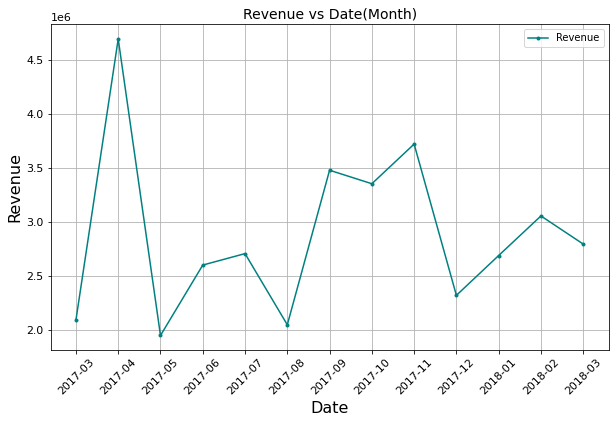

In [200]:
line_plot(date_Revenue['conv_date'],date_Revenue['revenue'],'Revenue','Revenue vs Date(Month)','Date','Revenue')

  conv_date       revenue  MonthlyGrowth
0   2017-03  2.091455e+06            NaN
1   2017-04  4.691490e+06       1.243171
2   2017-05  1.948590e+06      -0.584654
3   2017-06  2.599733e+06       0.334161
4   2017-07  2.705787e+06       0.040794


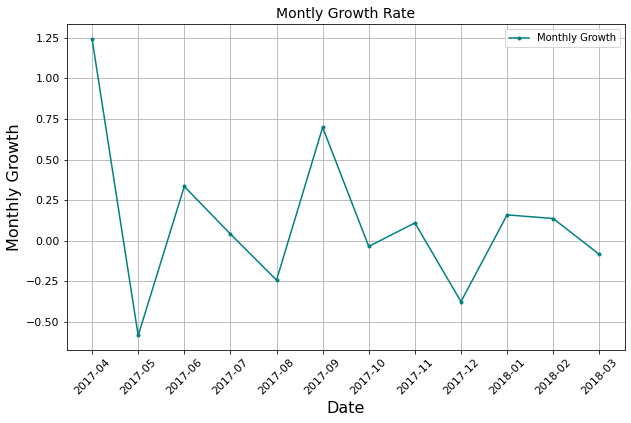

In [201]:
#monthly percentage change
date_Revenue['MonthlyGrowth'] = date_Revenue['revenue'].pct_change()
print(date_Revenue.head())
line_plot(date_Revenue['conv_date'],date_Revenue['MonthlyGrowth'],'Monthly Growth','Montly Growth Rate','Date','Monthly Growth')

**- Monthly active customers**

  conv_date  user_id
0   2017-03     4442
1   2017-04     8308
2   2017-05     4397
3   2017-06     5140
4   2017-07     5674


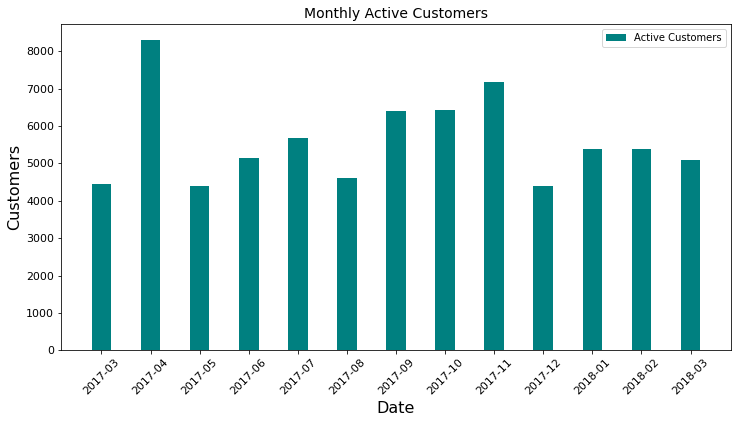

In [202]:
date_User=conversion_and_attribution.groupby(conversion_and_attribution['conv_date'].dt.strftime('%Y-%m'))['user_id'].nunique().reset_index()
print(date_User.head())
bar_plot(date_User['conv_date'],date_User['user_id'],'Active Customers','Monthly Active Customers','Date','Customers')

**- Performance and impact of different channels and how it changes over time**

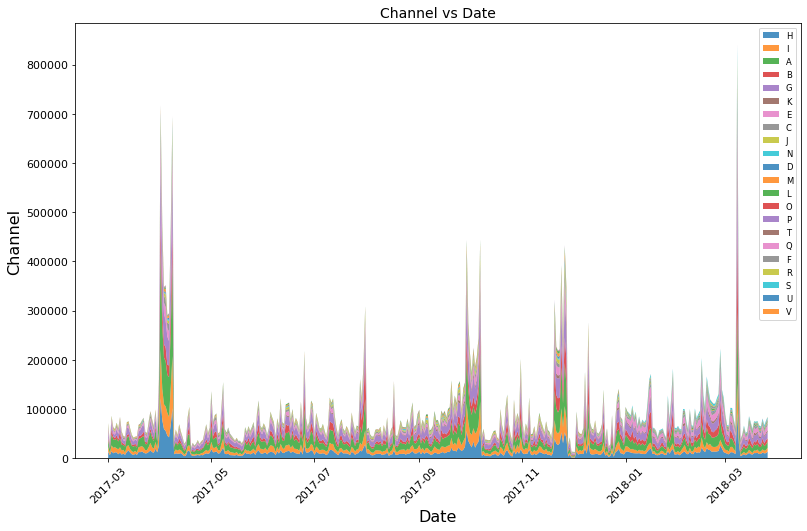

In [203]:
channels=conversion_and_attribution['channel'].unique()
date_grouped=conversion_and_attribution.groupby(['conv_date'])
date_channel_grouped=[]
plt.figure(figsize=(13,8))
for channel in channels:
    xx=date_grouped.apply(lambda x: x[x['channel'] == channel]['revenue'].sum())
    date_channel_grouped.append(xx)
x= xx.index
plt.stackplot( xx.index,
              date_channel_grouped,
              labels=channels,
              alpha=0.8)
plt.title('Channel vs Date',fontsize=14)
plt.xticks(rotation=45)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Channel',fontsize=16)
plt.rc('xtick',labelsize=11)
plt.rc('ytick',labelsize=11)
plt.legend( fontsize='small')
plt.show()

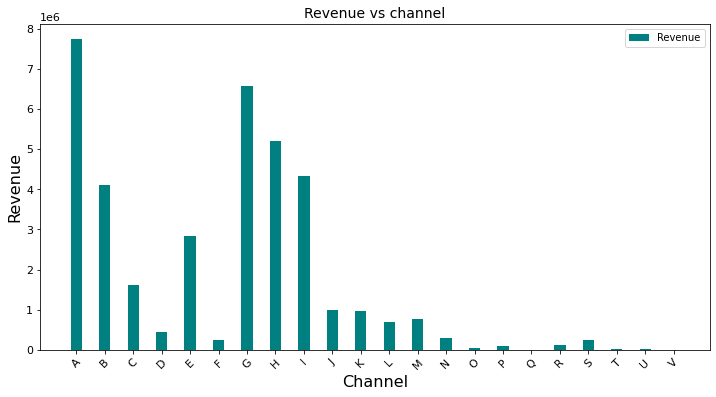

In [204]:
Revenue_Channnel=conversion_and_attribution.groupby(conversion_and_attribution['channel'])['revenue'].sum().reset_index()
bar_plot(Revenue_Channnel['channel'],Revenue_Channnel['revenue'],'Revenue','Revenue vs channel','Channel','Revenue')

<Figure size 792x576 with 0 Axes>

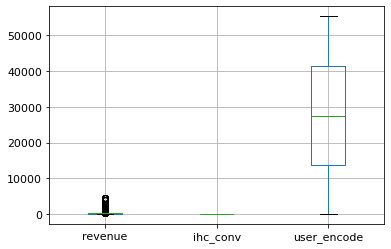

In [205]:
plt.figure(figsize=(11,8))
conversion_and_attribution.plot.box(grid='True')

**- Most influential channels per user**

In [206]:
user_channel_groupedby_revenue=conversion_and_attribution.groupby(['user_id','channel'])['revenue'].sum()
user_channel_groupedby_revenue.loc[user_channel_groupedby_revenue.groupby(level=0).idxmax()]


user_id                                   channel
00003ce67d6b73b2d49f4036f60cb73385a9c96e  A          153.840
0003509d64606735e66a3d32f2a1a084f613ee4b  I          245.632
00035f943a8a8e176fdd5a44059b38dcc0c73f5a  G          833.164
0003f10010cd3dadcb7182ed7b0abf5166393e91  G          121.808
0003fc733e4ff3bfb295f2c10c7077fb0763ebcc  A          108.720
                                                      ...   
fffb0fc0e6cde8d4838713679c0a6d3c28087671  G           97.336
fffc3a37495e0f44dbfe4511ec0d46460aa571e5  A          148.144
fffc95150d63e98e62d98cdfabbf13245fdc2dd2  A          210.800
fffe1f896de2470b64ae4895249f0a516f38e0db  B           84.628
fffe9ce5489133e44db3fa2c77d10c9cfa1fdb13  E           89.304
Name: revenue, Length: 55332, dtype: float64

# **Cohort Analysis**

**- Create a period column based on the OrderDate**

In [0]:
conversion_and_attribution['OrderPeriod'] = conversion_and_attribution.conv_date.apply(lambda x: x.strftime('%Y-%m'))

In [208]:
# Determine the user's cohort group (based on their first order)
conversion_and_attribution.set_index('user_encode', inplace=True)
conversion_and_attribution['CohortGroup'] = conversion_and_attribution.groupby(level=0)['conv_date'].min().apply(lambda x: x.strftime('%Y-%m'))
conversion_and_attribution.reset_index(inplace=True)
conversion_and_attribution.head()

,user_encode,conv_date,revenue,user_id,conv_id,channel,ihc_conv,OrderPeriod,CohortGroup
0,17496,2017-03-06,47.00000,5094298f068196c5349d43847de5afc9125cf989,881152bb20f9b73daafb99d77714f38ac702629c,H,1.000000,2017-03,2017-03
1,14668,2017-03-23,201.94104,433fdf385e33176cf9b0d67ecf383aa928fa261c,f0e6b7de22332c7b18c024e550bb1d860130cdf1,I,0.177042,2017-03,2017-03
2,14668,2017-03-23,201.94104,433fdf385e33176cf9b0d67ecf383aa928fa261c,f0e6b7de22332c7b18c024e550bb1d860130cdf1,A,0.573316,2017-03,2017-03
3,14668,2017-03-23,201.94104,433fdf385e33176cf9b0d67ecf383aa928fa261c,f0e6b7de22332c7b18c024e550bb1d860130cdf1,B,0.024867,2017-03,2017-03
4,14668,2017-03-23,201.94104,433fdf385e33176cf9b0d67ecf383aa928fa261c,f0e6b7de22332c7b18c024e550bb1d860130cdf1,G,0.057023,2017-03,2017-03


In [209]:
# Rollup data by CohortGroup & OrderPeriod
grouped = conversion_and_attribution.groupby(['CohortGroup', 'OrderPeriod'])

# Count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'user_encode': pd.Series.nunique,
                       'conv_id': pd.Series.nunique,
                       'revenue': np.sum})

# Make the column names more meaningful
cohorts.rename(columns={'user_encode': 'TotalUsers',
                        'conv_id': 'TotalOrders'}, inplace=True)
cohorts.head()

TotalUsers  TotalOrders       revenue
CohortGroup OrderPeriod                                       
2017-03     2017-03            4442         4923  2.091455e+06
            2017-04            1045         1234  8.315730e+05
            2017-05             636          775  4.034822e+05
            2017-06             568          665  4.068527e+05
            2017-07             540          619  3.540108e+05

In [210]:
#Label the CohortPeriod for each CohortGroup
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalUsers  TotalOrders       revenue  CohortPeriod
CohortGroup OrderPeriod                                                     
2017-03     2017-03            4442         4923  2.091455e+06             1
            2017-04            1045         1234  8.315730e+05             2
            2017-05             636          775  4.034822e+05             3
            2017-06             568          665  4.068527e+05             4
            2017-07             540          619  3.540108e+05             5

In [211]:
# Reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# Create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head(10)

CohortGroup
2017-03    4442
2017-04    7263
2017-05    3188
2017-06    3791
2017-07    4058
2017-08    3387
2017-09    4517
2017-10    4449
2017-11    5171
2017-12    3179
Name: TotalUsers, dtype: int64

In [212]:
#Divide the TotalUsers values in cohorts by cohort_group_size. 
cohorts['TotalUsers'].unstack(0).head()

CohortGroup,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
CohortPeriod,,,,,,,,,,,,,
1,4442.0,7263.0,3188.0,3791.0,4058.0,3387.0,4517.0,4449.0,5171.0,3179.0,4010.0,4066.0,3811.0
2,1045.0,573.0,187.0,182.0,124.0,147.0,132.0,138.0,81.0,60.0,88.0,83.0,NaN
3,636.0,594.0,218.0,137.0,130.0,120.0,147.0,61.0,59.0,62.0,65.0,NaN,NaN
4,568.0,676.0,161.0,152.0,117.0,109.0,79.0,59.0,52.0,42.0,NaN,NaN,NaN
5,540.0,404.0,218.0,153.0,137.0,52.0,93.0,53.0,65.0,NaN,NaN,NaN,NaN


In [213]:
#Utilize broadcasting to divide each column by the corresponding cohort_group_size.
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head()

CohortGroup,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
CohortPeriod,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.235254,0.078893,0.058657,0.048008,0.030557,0.043401,0.029223,0.031018,0.015664,0.018874,0.021945,0.020413,NaN
3,0.143179,0.081784,0.068381,0.036138,0.032035,0.035430,0.032544,0.013711,0.011410,0.019503,0.016209,NaN,NaN
4,0.127870,0.093074,0.050502,0.040095,0.028832,0.032182,0.017489,0.013261,0.010056,0.013212,NaN,NaN,NaN
5,0.121567,0.055624,0.068381,0.040359,0.033760,0.015353,0.020589,0.011913,0.012570,NaN,NaN,NaN,NaN


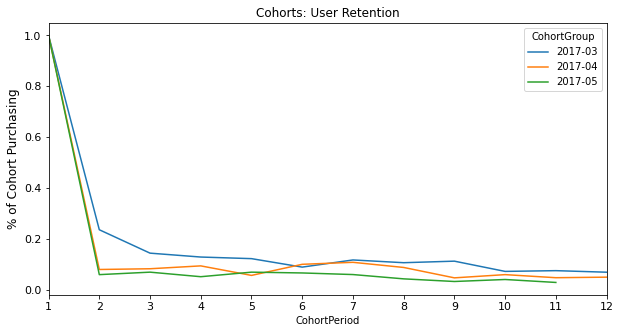

In [214]:
#Plot the cohorts over time in an effort to spot behavioral differences or similarities. 
user_retention[['2017-03', '2017-04', '2017-05']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing',fontsize=12);

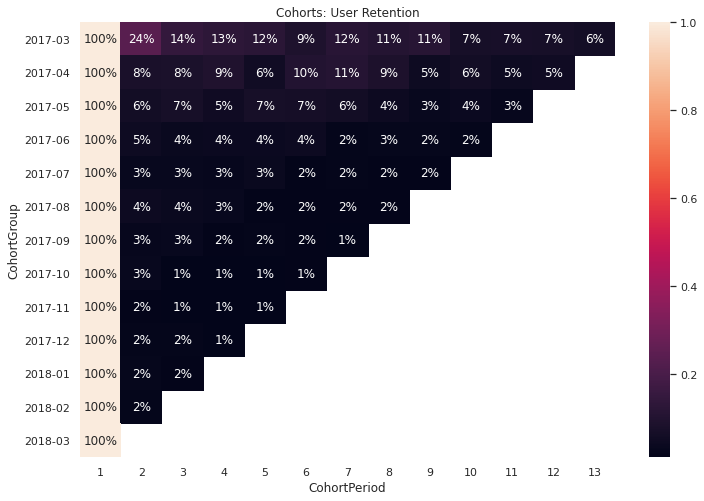

In [215]:
sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

**- Train and build a linear regression model**

In [0]:
channels=conversion_and_attribution['channel'].unique()
for single_channel in channels:
    conversion_and_attribution[single_channel]=np.where(conversion_and_attribution['channel']==single_channel,1,0)

In [217]:
drop_these = ['user_encode', 'conv_date', 'user_id','conv_id','channel','ihc_conv','OrderPeriod','CohortGroup']
df = conversion_and_attribution.drop(columns=drop_these)
df.head()

,revenue,H,I,A,B,G,K,E,C,J,N,D,M,L,O,P,T,Q,F,R,S,U,V
0,47.00000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,201.94104,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,201.94104,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,201.94104,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,201.94104,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
X = df.iloc[:, 1::].values
y = df.iloc[:, 0].values

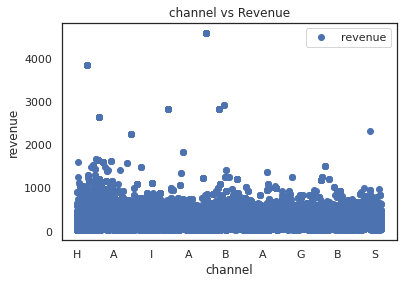

In [219]:
conversion_and_attribution.plot(x='channel', y='revenue', style='o')
plt.title('channel vs Revenue')
plt.xlabel('channel')
plt.ylabel('revenue')
plt.show()

In [220]:
reg = LinearRegression().fit(X, y)

print(reg.intercept_,reg.coef_,reg.score(X, y))

-155871709391440.72 [1.55871709e+14 1.55871709e+14 1.55871709e+14 1.55871709e+14
 1.55871709e+14 1.55871709e+14 1.55871709e+14 1.55871709e+14
 1.55871709e+14 1.55871709e+14 1.55871709e+14 1.55871709e+14
 1.55871709e+14 1.55871709e+14 1.55871709e+14 1.55871709e+14
 1.55871709e+14 1.55871709e+14 1.55871709e+14 1.55871709e+14
 1.55871709e+14 1.55871709e+14] 0.0057886788242546006


# **Customer Segmentation (RFM)**
Here, we want to calculate Recency, Frequency and Monetary Value (Revenue) and apply unsupervised machine learning to identify different groups (clusters) for each.


*   **Recency:** How recently a customer has made a purchase
*   **Frequency:** How often a customer makes a purchase
*   **Monetary Value:** How much money a customer spends on purchases




In [221]:
# Create a generic user dataframe to keep CustomerID and new segmentation scores
tx_user = pd.DataFrame(conversion_and_attribution['user_id'].unique())
tx_user.columns = ['CustomerID']

# Get the max purchase date for each customer and create a dataframe with it
tx_max_purchase = conversion_and_attribution.groupby('user_id').conv_date.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

# Max invoice date in our dataset
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')
tx_user.head()

,CustomerID,Recency
0,5094298f068196c5349d43847de5afc9125cf989,37
1,433fdf385e33176cf9b0d67ecf383aa928fa261c,41
2,59853624ad85789cc5c865405e741c612da334da,233
3,8b14ce0002a2a7adbe61c6386dd5b8b8a8435222,377
4,b7d38ff2747f3ebe3c6b4e6169dbb7c761177a2e,287


**- Recency**

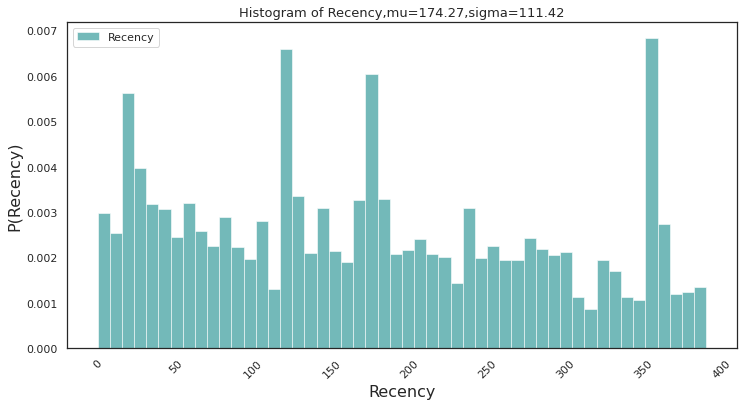

In [222]:
#plot a recency histogram
x=tx_user['Recency']
hist_plot(tx_user['Recency'],50,'Recency','Recency','Recency','P(Recency)')

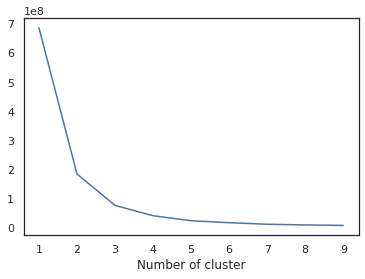

In [223]:
sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [0]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [225]:
tx_user.head()

,CustomerID,Recency,RecencyCluster
0,5094298f068196c5349d43847de5afc9125cf989,37,3
1,433fdf385e33176cf9b0d67ecf383aa928fa261c,41,3
2,5b9936196fabb28ea2c7d1b5c8da2414f4305480,87,3
3,f72dc9f432e94c591d28b0b6bb238f0b1127b74a,17,3
4,796e9b9f72ba3a46a6c686ea4e5b47a0614cec0e,18,3


In [226]:
#get order counts for each user and create a dataframe with it
tx_frequency = conversion_and_attribution.groupby('user_id').conv_date.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']

#add this data to our main dataframe
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,5094298f068196c5349d43847de5afc9125cf989,37,3,93
1,433fdf385e33176cf9b0d67ecf383aa928fa261c,41,3,20
2,5b9936196fabb28ea2c7d1b5c8da2414f4305480,87,3,11
3,f72dc9f432e94c591d28b0b6bb238f0b1127b74a,17,3,9
4,796e9b9f72ba3a46a6c686ea4e5b47a0614cec0e,18,3,15


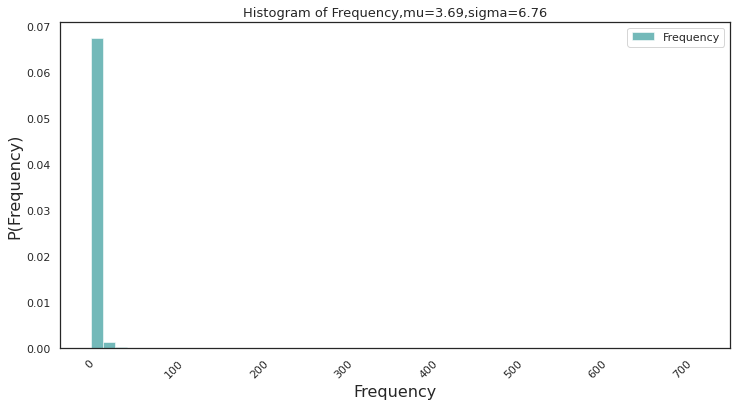

In [227]:
#plot the histogram
hist_plot(tx_user.query('Frequency < 1000')['Frequency'],50,'Frequency','Frequency','Frequency','P(Frequency)')

In [228]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

#order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

#see details of each cluster
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,51325.0,2.525046,1.714725,1.0,1.0,2.0,3.0,8.0
1,3693.0,15.201191,6.606317,9.0,10.0,13.0,18.0,36.0
2,313.0,57.399361,27.670282,37.0,42.0,49.0,62.0,334.0
3,1.0,720.000000,NaN,720.0,720.0,720.0,720.0,720.0


In [0]:
#calculate revenue for each customer
tx_revenue = conversion_and_attribution.groupby('user_id').revenue.sum().reset_index()
tx_revenue.columns=['CustomerID','Revenue']
#merge it with our main dataframe
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

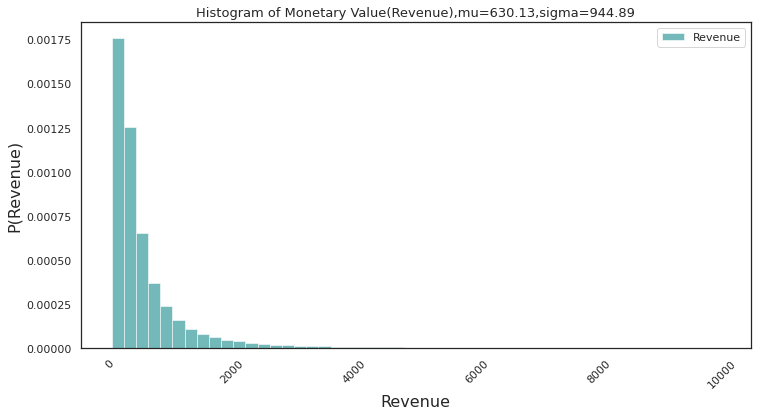

In [230]:
#plot the histogram
hist_plot(tx_user.query('Revenue < 10000')['Revenue'],50,'Revenue','Monetary Value(Revenue)','Revenue','P(Revenue)')

In [231]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])


#order the cluster numbers
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

#show details of the dataframe
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,51209.0,422.334130,350.565959,27.0588,167.95200,301.28000,562.38400,1713.37600
1,3730.0,2998.704025,1237.180497,1713.8800,2046.13800,2578.28576,3562.94200,6960.16480
2,389.0,10919.258333,4583.678818,6973.1920,8058.56000,9394.41200,12071.10800,36141.88224
3,4.0,107226.128900,53082.792225,65669.3520,77951.22411,89339.01274,118613.91753,184557.13812


In [232]:
#calculate overall score and use mean() to see details
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user.head()
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,Recency,Frequency,Revenue
OverallScore,,,
0,345.355330,2.193268,377.092828
1,248.853626,2.444201,399.132436
2,150.890571,2.667140,462.721984
3,52.145738,3.105960,541.415244
4,95.226190,12.160401,2500.335761
5,41.623614,17.663405,3515.454854
6,52.187845,36.403315,8391.994291
7,31.316279,59.506977,12625.599645
8,7.500000,254.500000,73857.266740


In [0]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

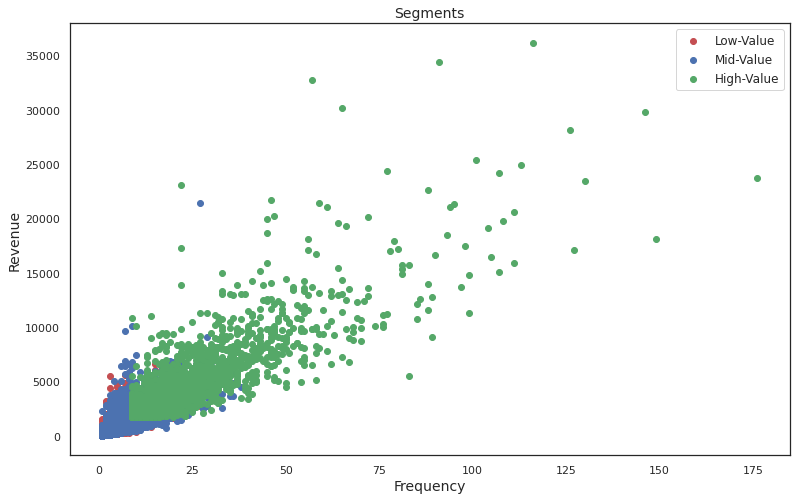

In [234]:
#Revenue vs Frequency
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")
scatter_plot(tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        tx_graph.query("Segment == 'Low-Value'")['Revenue'],tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        tx_graph.query("Segment == 'Mid-Value'")['Revenue'],tx_graph.query("Segment == 'High-Value'")['Frequency'],
        tx_graph.query("Segment == 'High-Value'")['Revenue'],'Frequency','Revenue')

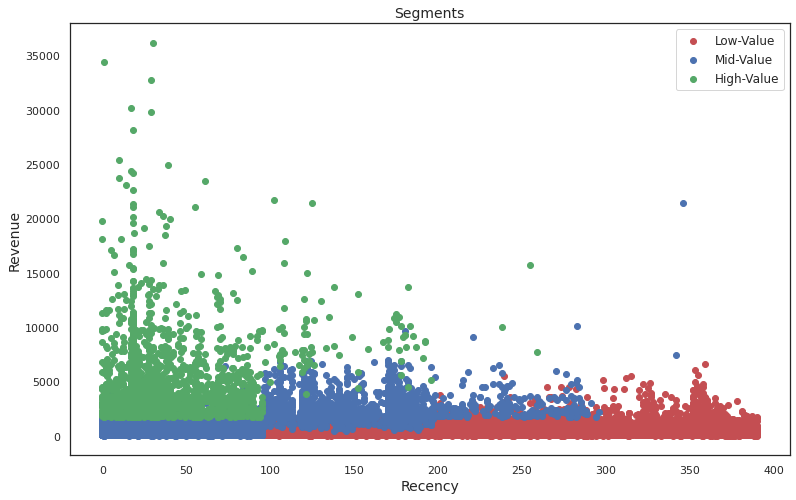

In [235]:
#Revenue vs Recency
scatter_plot(tx_graph.query("Segment == 'Low-Value'")['Recency'],
        tx_graph.query("Segment == 'Low-Value'")['Revenue'],tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        tx_graph.query("Segment == 'Mid-Value'")['Revenue'],tx_graph.query("Segment == 'High-Value'")['Recency'],
        tx_graph.query("Segment == 'High-Value'")['Revenue'],'Recency','Revenue')

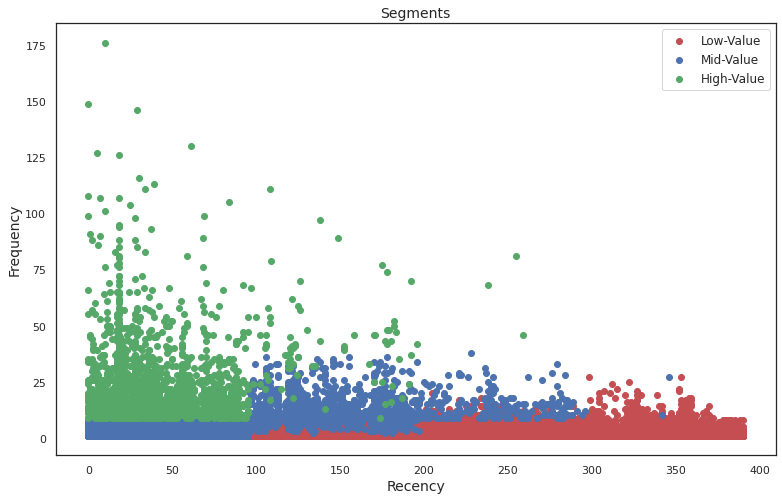

In [236]:
#Frequency vs Recency
scatter_plot(tx_graph.query("Segment == 'Low-Value'")['Recency'],
        tx_graph.query("Segment == 'Low-Value'")['Frequency'],tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        tx_graph.query("Segment == 'Mid-Value'")['Frequency'],tx_graph.query("Segment == 'High-Value'")['Recency'],
        tx_graph.query("Segment == 'High-Value'")['Frequency'],'Recency','Frequency')